# xSDR: Speaker-Independent Spoken Digit Recognition
This is our solution for the final graded project for the WS22/23 course "_Neural Networks: Theory and Implementation_" at Saarland University.
<br/>
Authors: _Christian Singer, Mhd Jawad Al Rahwanji_
`{chsi00002, mhal00002}@stud.uni-saarland.de`
<br/>
<img src="xSDR.png" height=333>

##### Before we start, we'd like to point out a couple of things:

-- An **Introduction** to the project can be found in `README.md`

-- Some preliminary **Data Exploration** can be found in `DataExploration.ipynb`

### Imports

In [1]:
# add this to ignore warnings from Librosa
import warnings
import os

warnings.filterwarnings('ignore')

In [2]:
base = os.getcwd()

### Task I

In [3]:
# I.1

from model_baseline.data_loading import downsample_spectrogram

downsample_spectrogram

<function model_baseline.data_loading.downsample_spectrogram(spectrogram, num_frames)>

In [4]:
# I.2

from model_baseline.data_loading import create_features

trnf, trnl = create_features("TRAIN")
devf, devl = create_features("DEV")
tstf, tstl = create_features("TEST")

In [5]:
# I.3

from model_baseline.linear_model import classifier

# Both penalty and loss parameters were experimented with,
# "elasticnet" and "modified_huber" were chosen, respectively.
classifier

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(loss='modified_huber', n_jobs=-1,
                               penalty='elasticnet'))])

In [6]:
# I.4

%run 'model_baseline/linear_model.py'

----------------------------------TRAIN-SET----------------------------------------
Confusion matrix:
[[189   1   1   3   1   0   0   5   0   0]
 [  0 186   0   1   2   3   0   4   0   4]
 [  0   4 172  23   1   0   0   0   0   0]
 [  0   1  10 185   0   0   0   4   0   0]
 [  3  13   0   0 181   1   1   1   0   0]
 [  1  13   0   0   0 168   0   5   0  13]
 [  0   0   1  25   0   0 153   6  15   0]
 [  1   6   0   8   1   1   2 175   1   5]
 [  0   0   0   8   0   0  14   4 173   1]
 [  0   3   0   3   0   1   0   6   0 187]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       200
           1       0.82      0.93      0.87       200
           2       0.93      0.86      0.90       200
           3       0.72      0.93      0.81       200
           4       0.97      0.91      0.94       200
           5       0.97      0.84      0.90       200
           6       0.90      0.77      0.83       200
          

### Task II

In [7]:
# II.1

from model_neural.transformer_model import TransformerModel
from model_neural.conv1d_model import Conv1dModel, Conv1dMelModel

# Answers to subquestions first:
# Yes, both neural models outperformed our baseline model.
# TODO: Await latest model evaluations...
# TODO: Fill with answer to:  "Do you observe any signs of overfitting to the training data?"
# TODO: Fill with answer to:  "How do the hyperparameters affect the model performance?"
# TODO: Discuss the above observations after reporting them
print(Conv1dModel)
print(Conv1dMelModel)

TransformerModel

<class 'model_neural.conv1d_model.Conv1dModel'>
<class 'model_neural.conv1d_model.Conv1dMelModel'>


model_neural.transformer_model.TransformerModel

In [8]:
# II.2

# TODO: Also await latest model evaluations...
# We have the classification report for the baseline model
# Now, we produce the classification report for the best models

os.chdir(base + '/model_neural')
%run 'classification_report.py'
os.chdir(base)

# TODO: Compare the classification reports

Using: 'cpu' as device for report.

Confusion matrix of train-set:
 tensor([[ 20,   0,   0,   0,   0,   0, 173,   0,   7,   0],
        [  0,  24,   0,   0,   7,   4, 159,   0,   5,   1],
        [  0,   0,   9,   0,   0,   0, 191,   0,   0,   0],
        [  0,   0,   9,   2,   0,   0, 189,   0,   0,   0],
        [  0,   0,   0,   0,  28,   2, 165,   0,   5,   0],
        [  0,   0,   0,   0,   2,  54, 129,   0,  15,   0],
        [  0,   0,   0,   0,   7,   0, 179,   0,  14,   0],
        [  0,   0,   1,   0,  15,   0, 162,   5,  17,   0],
        [  0,   0,   0,   0,   0,   0, 167,   0,  33,   0],
        [  0,  17,  11,   4,   1,  25, 105,   3,  13,  21]])

Classification report: train-set:
 class   precision   recall   f1-score
     0      1.00       0.10       0.18       
     1      0.59       0.12       0.20       
     2      0.30       0.05       0.08       
     3      0.33       0.01       0.02       
     4      0.47       0.14       0.22       
     5      0.64       0.27

Using: 'cpu' as device for report.
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 497 samples in 0.000s...
[t-SNE] Computed neighbors for 497 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 497 / 497
[t-SNE] Mean sigma: 3.108445
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.834549
[t-SNE] KL divergence after 300 iterations: 0.621863


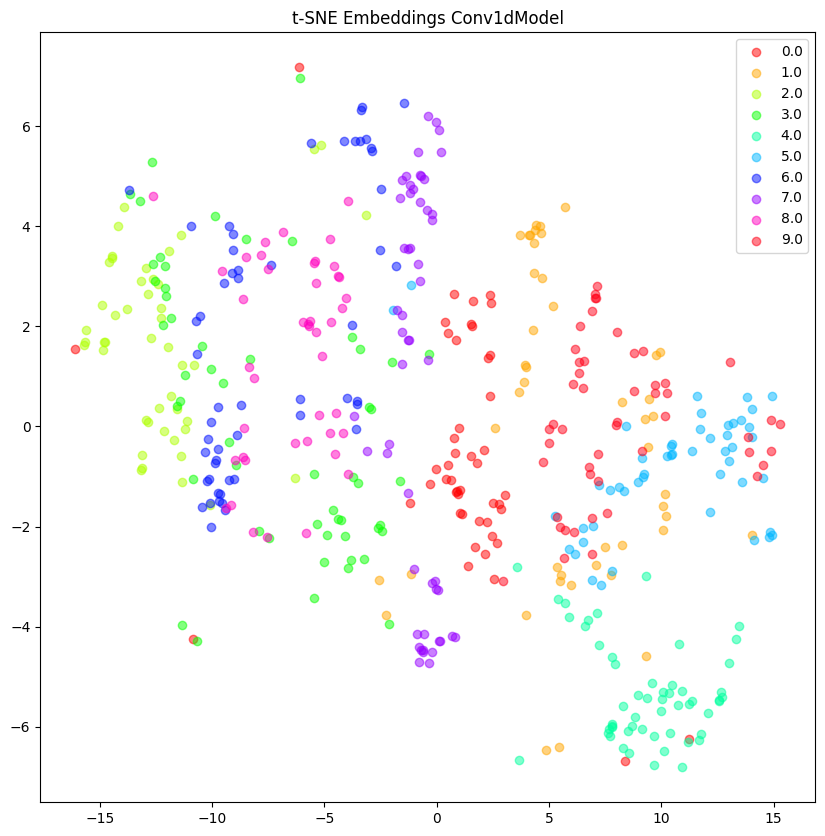

In [9]:
# II.3

os.chdir(base + "/comparative_analysis")
%run 'tsne_model_embeddings.py'
os.chdir(base)

# TODO: Do the same for linear model

# TODO: Compare to the baseline after reporting

In [10]:
# II.4

from comparative_analysis.statistical_significance_test import test_statistical_significance

test_statistical_significance

# TODO: Compare and report all 3 models after pairwise signif. testing

<function comparative_analysis.statistical_significance_test.test_statistical_significance(model, baseline, device: torch.device)>

### Task III

In [11]:
# III.1

# Answers to subquestions first:
# TODO: Await latest model evaluations...
# TODO: Fill with answer to:  "What do you observe?"
# TODO: Fill with answer to:  "How does this affect the model performance?"
# TODO: Discuss the above observations after reporting them

# TODO: Retrain all 3 using new dataloader

In [12]:
# III.2

# TODO: Complete.

In [13]:
# III.3

# TODO: Complete.